In [1]:
# Python Code for Group Work Machine Learning
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import json_normalize
import glob

In [2]:
# Get all JSON files in the directory
file_paths = glob.glob(r'raw_data_rotterdam (1)/*.json')

# Read and concatenate all JSON files
df_list = [pd.read_json(file) for file in file_paths]
df = pd.concat(df_list, ignore_index=True)

# Normalize the nested JSON data
df_normalized = json_normalize(df['data'])

In [3]:
# list of columns to keep
keep = ['navigation.time', 
        'navigation.location.long', 'navigation.location.lat', 
        'navigation.destination.name', 
        'navigation.destination.eta', 'navigation.status', 
        'device.mmsi', 
        'vessel.type', 
        'vessel.imo', 'vessel.name']

# filter the columns
df_keep = df_normalized[keep]

In [4]:
# convert the time to datetime
df_keep = df_keep.copy()
df_keep['navigation.time'] = pd.to_datetime(df_keep['navigation.time'])
df_keep['day'] = df_keep['navigation.time'].dt.day
df_keep['hour'] = df_keep['navigation.time'].dt.hour
df_keep['minute'] = df_keep['navigation.time'].dt.minute

In [5]:
df_keep['vessel.name'].value_counts()

vessel.name
TRUDIE            8909
JORDY-M           8906
CHARLOIS          8721
LEVANTE           8202
WESTERSCHELDE     7469
ROMEE             7198
JAN LEEGHWATER    7009
CAAN              7008
HELENA            6414
AARBURG           6339
ORION             1982
SUNMI             1128
MARIBO MAERSK      691
MAYVIEW MAERSK      25
CHARL                5
MKXTG C              2
JORDY CD1            1
8ELENA               1
"5FPV                1
MARIB                1
QE0>0                1
TRUDIH&'L            1
Name: count, dtype: int64

In [6]:
# remove vessel.name with less than 10 occurrences
df_keep = df_keep.groupby('vessel.name').filter(lambda x: len(x) > 10)

# for each vessel.name, create a new dataframe
df_vessels = {}
for vessel in df_keep['vessel.name'].unique():
    df_vessels[vessel] = df_keep[df_keep['vessel.name'] == vessel]

# drop MAYVIEW MAERSK from the dictionary
df_vessels.pop('MAYVIEW MAERSK')

# show the keys of the dictionary with their size
for key in df_vessels.keys():
    print(key, df_vessels[key].shape)

JAN LEEGHWATER (7009, 13)
AARBURG (6339, 13)
ORION (1982, 13)
LEVANTE (8202, 13)
JORDY-M (8906, 13)
HELENA (6414, 13)
CHARLOIS (8721, 13)
TRUDIE (8909, 13)
CAAN (7008, 13)
ROMEE (7198, 13)
WESTERSCHELDE (7469, 13)
SUNMI (1128, 13)
MARIBO MAERSK (691, 13)


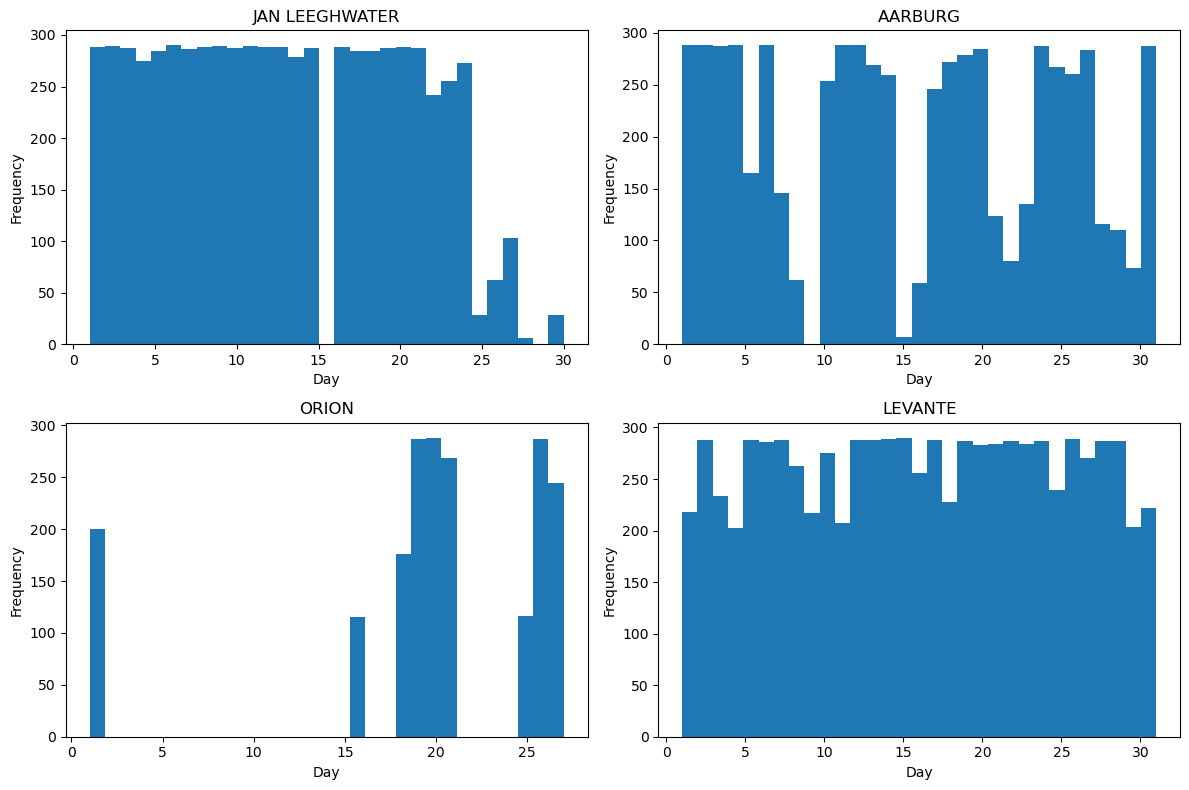

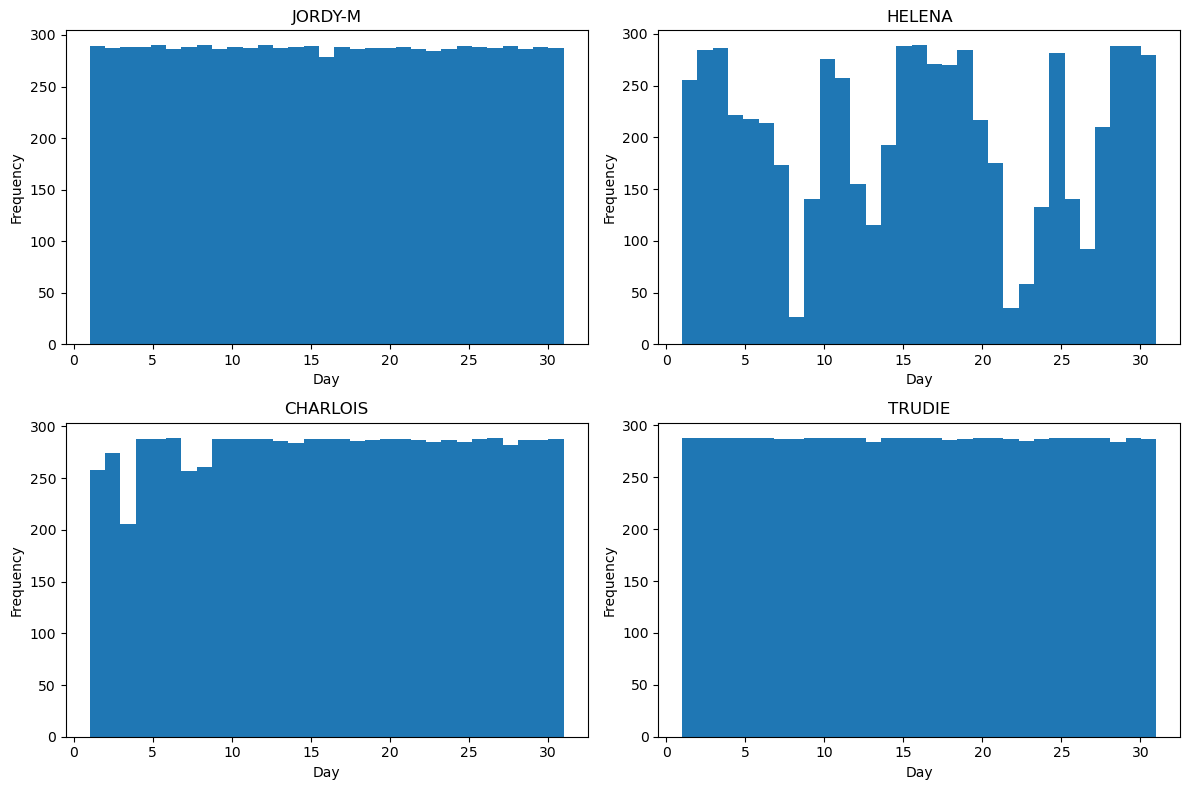

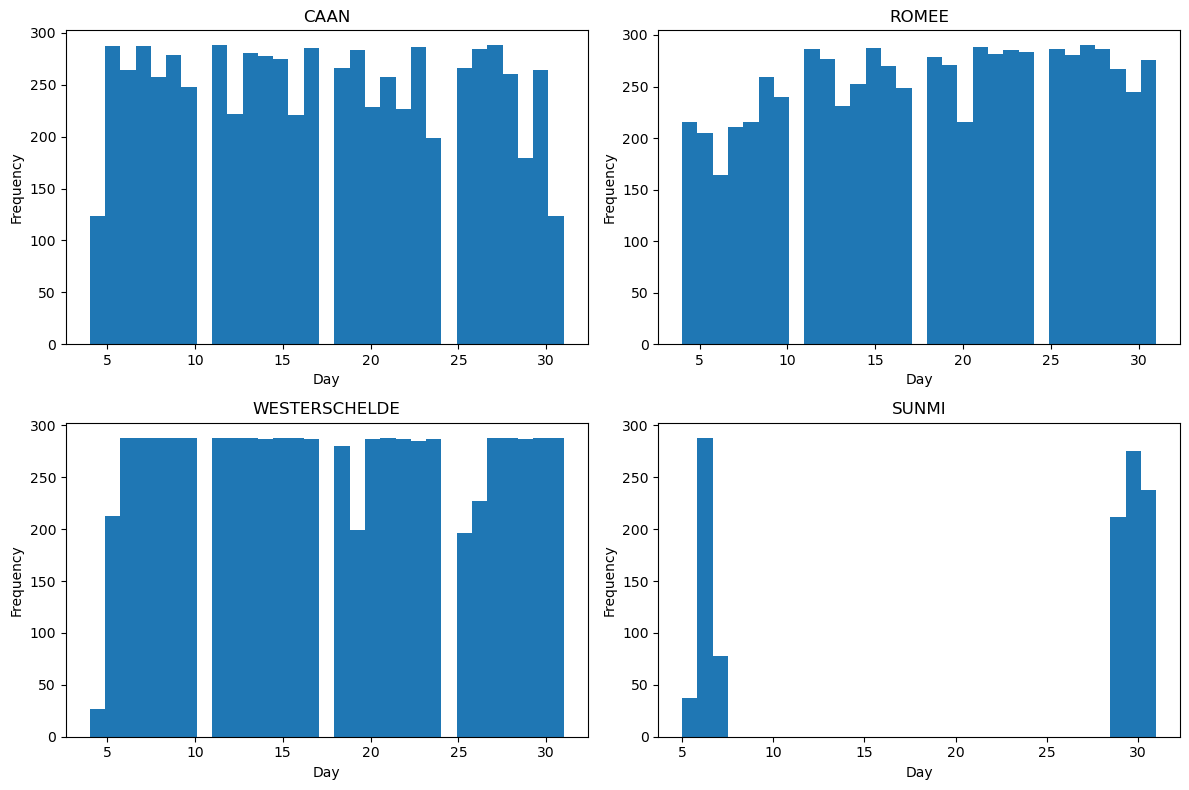

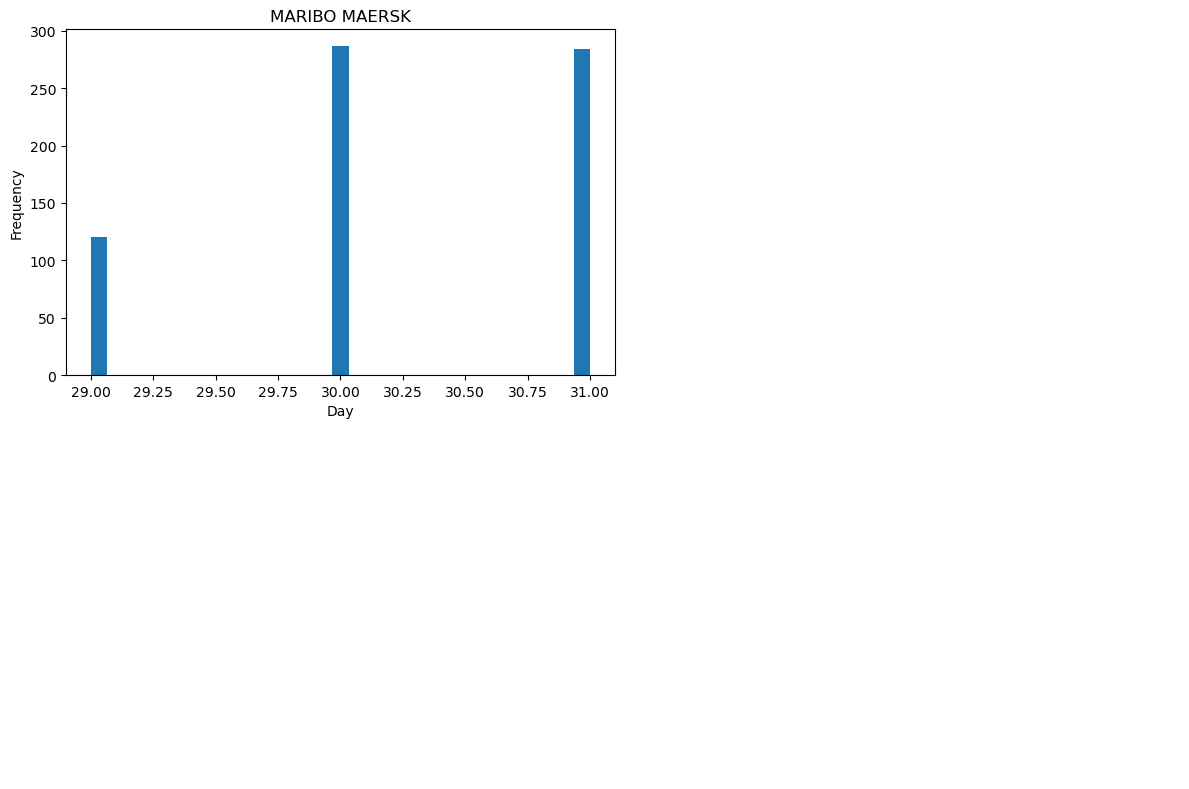

In [7]:
# Divide vessels into chunks of 4 and plot each chunk in a 2x2 grid
vessel_names = list(df_vessels.keys())
num_vessels = len(vessel_names)
vessels_per_plot = 4

for start in range(0, num_vessels, vessels_per_plot):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # Create a 2x2 grid of subplots
    axes = axes.flatten()  # Flatten the axes array for easier iteration

    for i, key in enumerate(vessel_names[start:start + vessels_per_plot]):
        axes[i].hist(df_vessels[key]['day'], bins=31)
        axes[i].set_title(key)
        axes[i].set_xlabel('Day')
        axes[i].set_ylabel('Frequency')

    # Hide unused subplots
    for j in range(len(vessel_names[start:start + vessels_per_plot]), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [8]:
import ipywidgets as widgets
from IPython.display import display
from mpl_toolkits.basemap import Basemap

In [9]:
# import ipywidgets as widgets
# from IPython.display import display
# from mpl_toolkits.basemap import Basemap

# Create a dropdown widget for selecting a day
unique_days = sorted(df_keep['day'].unique())
day_dropdown = widgets.Dropdown(
    options=[('All Days', None)] + [(f'Day {day}', day) for day in unique_days],
    value=None,
    description='Day:',
)

# Function to update the map based on the selected day
def update_map(day):
    fig, ax = plt.subplots(figsize=(12, 12))
    m = Basemap(projection='merc', llcrnrlat=51.5, urcrnrlat=52.5,
                llcrnrlon=3.5, urcrnrlon=5.5, resolution='i', ax=ax)

    # Draw coastlines, countries, and map boundaries
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary(fill_color='aqua')
    m.fillcontinents(color='lightgray', lake_color='aqua')

    # Plot the datapoints for the selected vessels
    for key in ['ORION', 'SUNMI', 'MARIBO MAERSK']:
        vessel_data = df_vessels[key]
        if day is not None:
            vessel_data = vessel_data[vessel_data['day'] == day]
        x, y = m(vessel_data['navigation.location.long'].values,
                 vessel_data['navigation.location.lat'].values)
        ax.scatter(x, y, label=key)

    ax.legend()
    plt.show()

# Link the dropdown to the update_map function
interactive_plot = widgets.interactive(update_map, day=day_dropdown)

# Display the dropdown and the interactive plot
display(day_dropdown, interactive_plot)

Dropdown(description='Day:', options=(('All Days', None), ('Day 1', np.int32(1)), ('Day 2', np.int32(2)), ('Da…

interactive(children=(Dropdown(description='Day:', options=(('All Days', None), ('Day 1', np.int32(1)), ('Day …

In [10]:
# Create a dropdown widget for selecting a vessel
vessel_dropdown = widgets.Dropdown(
    options=[(name, name) for name in df_vessels.keys()],
    value=list(df_vessels.keys())[0],
    description='Vessel:',
)

# Function to update the map based on the selected vessel
def update_vessel_map(vessel_name):
    fig, ax = plt.subplots(figsize=(16, 16))  # Increased the figure size
    m = Basemap(projection='merc', llcrnrlat=49.0, urcrnrlat=54.0,
                llcrnrlon=3.0, urcrnrlon=9.5, resolution='i', ax=ax)

    # Draw coastlines, countries, and map boundaries
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary(fill_color='aqua')
    m.fillcontinents(color='lightgray', lake_color='aqua')

    # Plot the datapoints for the selected vessel
    vessel_data = df_vessels[vessel_name]
    x, y = m(vessel_data['navigation.location.long'].values,
             vessel_data['navigation.location.lat'].values)
    ax.scatter(x, y, label=vessel_name, color='red')

    ax.legend()
    plt.show()

# Link the dropdown to the update_vessel_map function
interactive_vessel_plot = widgets.interactive(update_vessel_map, vessel_name=vessel_dropdown)

# Display the dropdown and the interactive plot
display(vessel_dropdown, interactive_vessel_plot)

Dropdown(description='Vessel:', options=(('JAN LEEGHWATER', 'JAN LEEGHWATER'), ('AARBURG', 'AARBURG'), ('ORION…

interactive(children=(Dropdown(description='Vessel:', options=(('JAN LEEGHWATER', 'JAN LEEGHWATER'), ('AARBURG…

In [11]:
# ---- Create resulting dataframes ----

# A: strict dataframe for rotterdam port area = vessels which have data for this area
vessels_slim_rotterdam = ['AARBURG', 'LEVANTE', 'JORDY-M', 'CHARLOIS', 'TRUDIE', 'CAAN', 'ROMEE', 'WESTERSCHELDE']
df_slim_rotterdam = pd.concat([df_vessels[vessel] for vessel in vessels_slim_rotterdam])

# only coordinates in this area 
df_slim_rotterdam = df_slim_rotterdam[(df_slim_rotterdam['navigation.location.lat'] > 51.8) & 
                                      (df_slim_rotterdam['navigation.location.lat'] < 52.0) & 
                                      (df_slim_rotterdam['navigation.location.long'] > 4.0) & 
                                      (df_slim_rotterdam['navigation.location.long'] < 4.6)]

# B: strict dataframe for rotterdam area with additionally ORION, SUNMI, MARIBO MAERSK
vessels_wide_rotterdam = ['AARBURG', 'LEVANTE', 'JORDY-M', 'CHARLOIS', 'TRUDIE', 'CAAN', 'ROMEE', 'WESTERSCHELDE', 'ORION', 'SUNMI', 'MARIBO MAERSK']
df_wide_rotterdam = pd.concat([df_vessels[vessel] for vessel in vessels_wide_rotterdam])

# only coordinates in this area
df_wide_rotterdam = df_wide_rotterdam[(df_wide_rotterdam['navigation.location.lat'] > 51.8) & 
                                      (df_wide_rotterdam['navigation.location.lat'] < 52.0) & 
                                      (df_wide_rotterdam['navigation.location.long'] > 4.0) & 
                                      (df_wide_rotterdam['navigation.location.long'] < 4.6)]


# C: dataframes with all moving vessels, only exclude points below frankfurt as they are disconnected from the rest
vessels_all = vessels_wide_rotterdam + ['HELENA']     # so all vessels except JAN LEEGHWATER
df_all = pd.concat([df_vessels[vessel] for vessel in vessels_all])

# remove datapoints below frankfurt
df_all = df_all[df_all['navigation.location.lat'] > 50.5]


df_slim_rotterdam.describe()

,navigation.location.long,navigation.location.lat,device.mmsi,vessel.imo,day,hour,minute
count,30043.000000,30043.000000,3.004300e+04,30043.0,30043.000000,30043.000000,30043.000000
mean,4.201717,51.918206,2.413457e+08,0.0,15.901341,11.412642,28.825017
std,0.178552,0.039834,9.788899e+06,0.0,8.605918,6.844214,17.265774
min,4.000020,51.805470,2.115602e+08,0.0,1.000000,0.000000,0.000000
25%,4.032980,51.881020,2.446300e+08,0.0,8.000000,6.000000,15.000000
50%,4.169250,51.930500,2.446307e+08,0.0,16.000000,11.000000,30.000000
75%,4.376845,51.957740,2.447008e+08,0.0,23.000000,17.000000,45.000000
max,4.599940,51.979860,2.447500e+08,0.0,31.000000,23.000000,59.000000


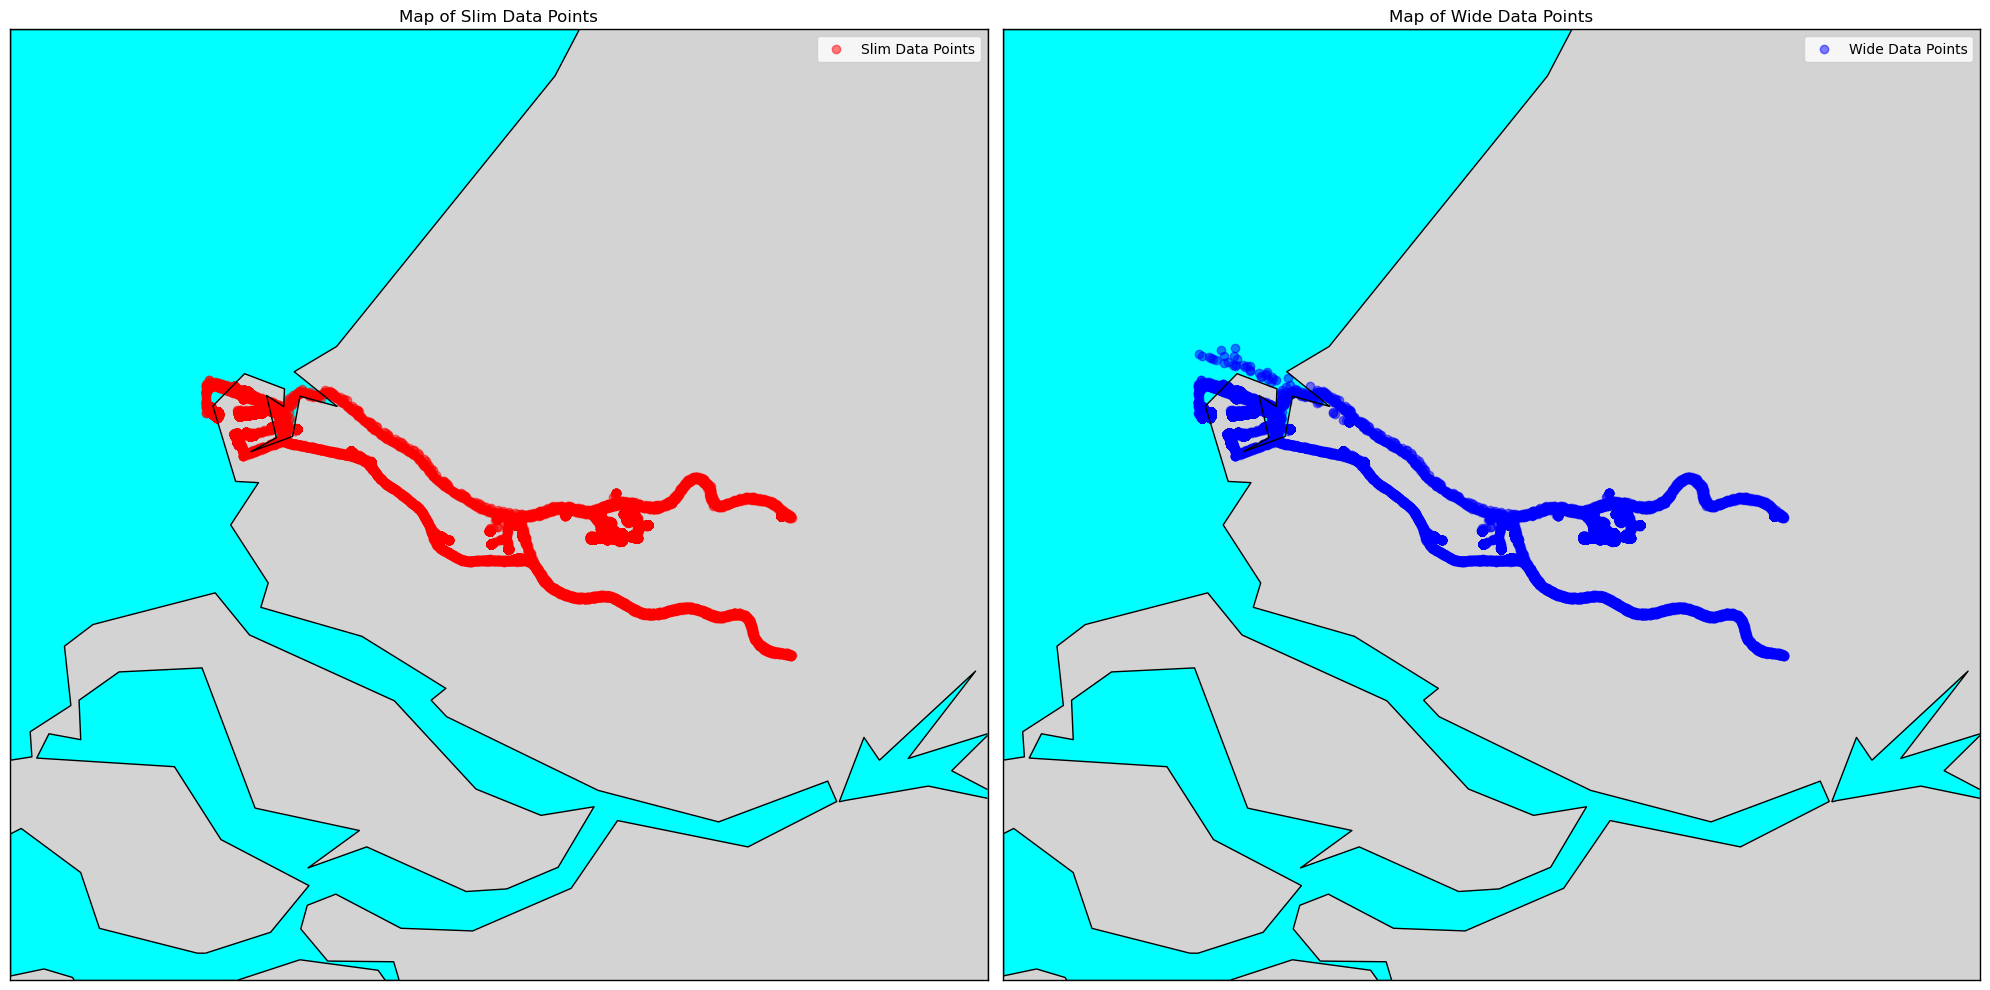

In [12]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 12))

# First subplot: Map with datapoints from df_slim_rotterdam
m1 = Basemap(projection='merc', llcrnrlat=51.6, urcrnrlat=52.2,
             llcrnrlon=3.8, urcrnrlon=4.8, resolution='i', ax=axes[0])

# Draw coastlines, countries, and map boundaries
m1.drawcoastlines()
m1.drawcountries()
m1.drawmapboundary(fill_color='aqua')
m1.fillcontinents(color='lightgray', lake_color='aqua')

# Plot the datapoints from df_slim_rotterdam
x_slim, y_slim = m1(df_slim_rotterdam['navigation.location.long'].values,
                    df_slim_rotterdam['navigation.location.lat'].values)
axes[0].scatter(x_slim, y_slim, marker='o', color='red', alpha=0.5, label='Slim Data Points')

axes[0].legend()
axes[0].set_title('Map of Slim Data Points')

# Second subplot: Map with datapoints from df_wide_rotterdam
m2 = Basemap(projection='merc', llcrnrlat=51.6, urcrnrlat=52.2,
             llcrnrlon=3.8, urcrnrlon=4.8, resolution='i', ax=axes[1])

# Draw coastlines, countries, and map boundaries
m2.drawcoastlines()
m2.drawcountries()
m2.drawmapboundary(fill_color='aqua')
m2.fillcontinents(color='lightgray', lake_color='aqua')

# Plot the datapoints from df_wide_rotterdam
x_wide, y_wide = m2(df_wide_rotterdam['navigation.location.long'].values,
                    df_wide_rotterdam['navigation.location.lat'].values)
axes[1].scatter(x_wide, y_wide, marker='o', color='blue', alpha=0.5, label='Wide Data Points')

axes[1].legend()
axes[1].set_title('Map of Wide Data Points')

plt.tight_layout()
plt.show()

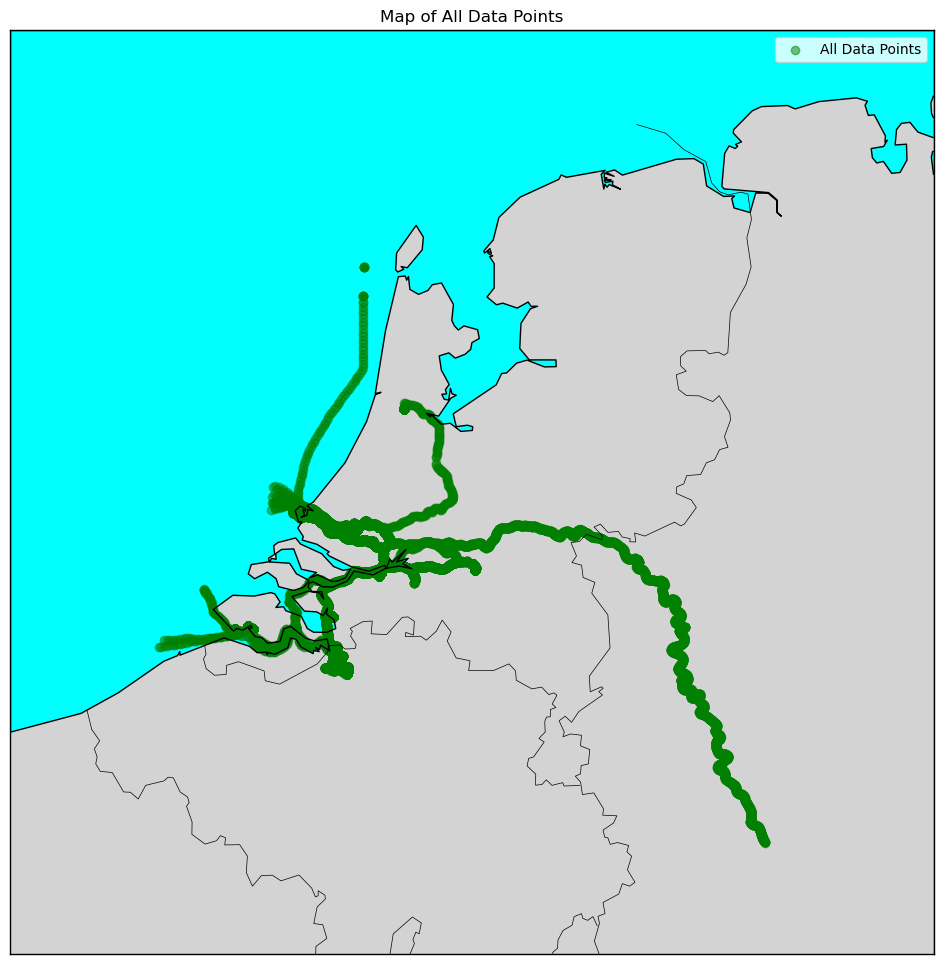

In [13]:
# Create a map to plot datapoints from df_all
fig, ax = plt.subplots(figsize=(12, 12))

# Initialize the Basemap
m3 = Basemap(projection='merc', llcrnrlat=50.0, urcrnrlat=54.0,
             llcrnrlon=2.0, urcrnrlon=8.5, resolution='i', ax=ax)

# Draw coastlines, countries, and map boundaries
m3.drawcoastlines()
m3.drawcountries()
m3.drawmapboundary(fill_color='aqua')
m3.fillcontinents(color='lightgray', lake_color='aqua')

# Plot the datapoints from df_all
x_all, y_all = m3(df_all['navigation.location.long'].values,
                  df_all['navigation.location.lat'].values)
ax.scatter(x_all, y_all, marker='o', color='green', alpha=0.5, label='All Data Points')

ax.legend()
ax.set_title('Map of All Data Points')

plt.show()

In [14]:
from sklearn.cluster import KMeans, DBSCAN
from mpl_toolkits.basemap import Basemap

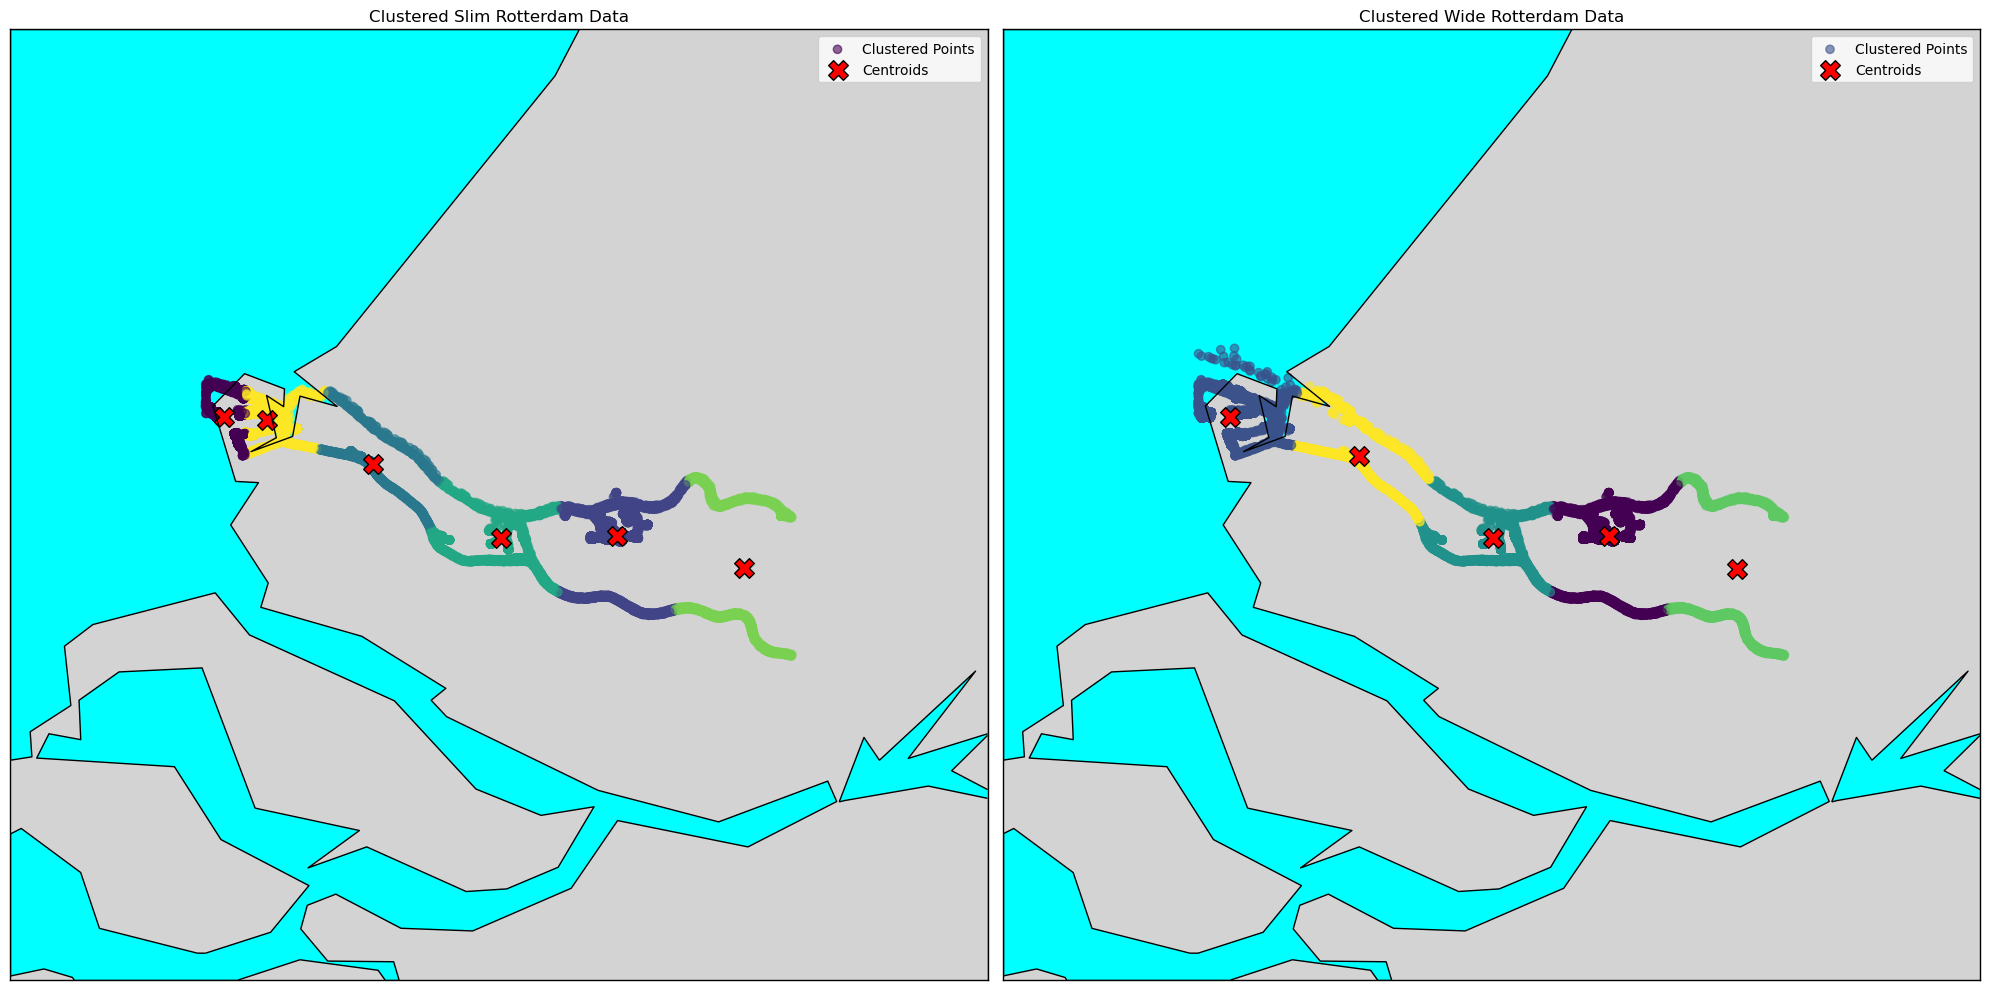

In [15]:
# Function to apply clustering and plot results with centroids
def plot_clustered_map(df, title, ax, clustering_method='kmeans', n_clusters=4):
    # Extract coordinates
    coords = df[['navigation.location.long', 'navigation.location.lat']].values
    
    # Apply clustering
    if clustering_method == 'kmeans':
        model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        clusters = model.fit_predict(coords)
        centroids = model.cluster_centers_
    elif clustering_method == 'dbscan':
        model = DBSCAN(eps=0.01, min_samples=5)  # Adjust parameters as needed
        clusters = model.fit_predict(coords)
        centroids = None  # DBSCAN does not have centroids
    else:
        raise ValueError("Invalid clustering method")
    
    df['cluster'] = clusters
    
    # Create Basemap
    m = Basemap(projection='merc', llcrnrlat=51.6, urcrnrlat=52.2,
                llcrnrlon=3.8, urcrnrlon=4.8, resolution='i', ax=ax)
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary(fill_color='aqua')
    m.fillcontinents(color='lightgray', lake_color='aqua')
    
    # Map coordinates to Basemap projection
    x, y = m(df['navigation.location.long'].values, df['navigation.location.lat'].values)
    
    # Plot clusters
    scatter = ax.scatter(x, y, c=df['cluster'], cmap='viridis', alpha=0.6, label='Clustered Points')
    
    # Plot centroids if available
    if clustering_method == 'kmeans' and centroids is not None:
        centroids_x, centroids_y = m(centroids[:, 0], centroids[:, 1])
        ax.scatter(centroids_x, centroids_y, marker='X', s=200, c='red', edgecolors='black', label='Centroids')
    
    ax.legend()
    ax.set_title(title)
    
    return scatter

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 12))

# Plot clustered maps for slim and wide datasets
plot_clustered_map(df_slim_rotterdam, 'Clustered Slim Rotterdam Data', axes[0], clustering_method='kmeans', n_clusters=6)
plot_clustered_map(df_wide_rotterdam, 'Clustered Wide Rotterdam Data', axes[1], clustering_method='kmeans', n_clusters=5)

plt.tight_layout()
plt.show()

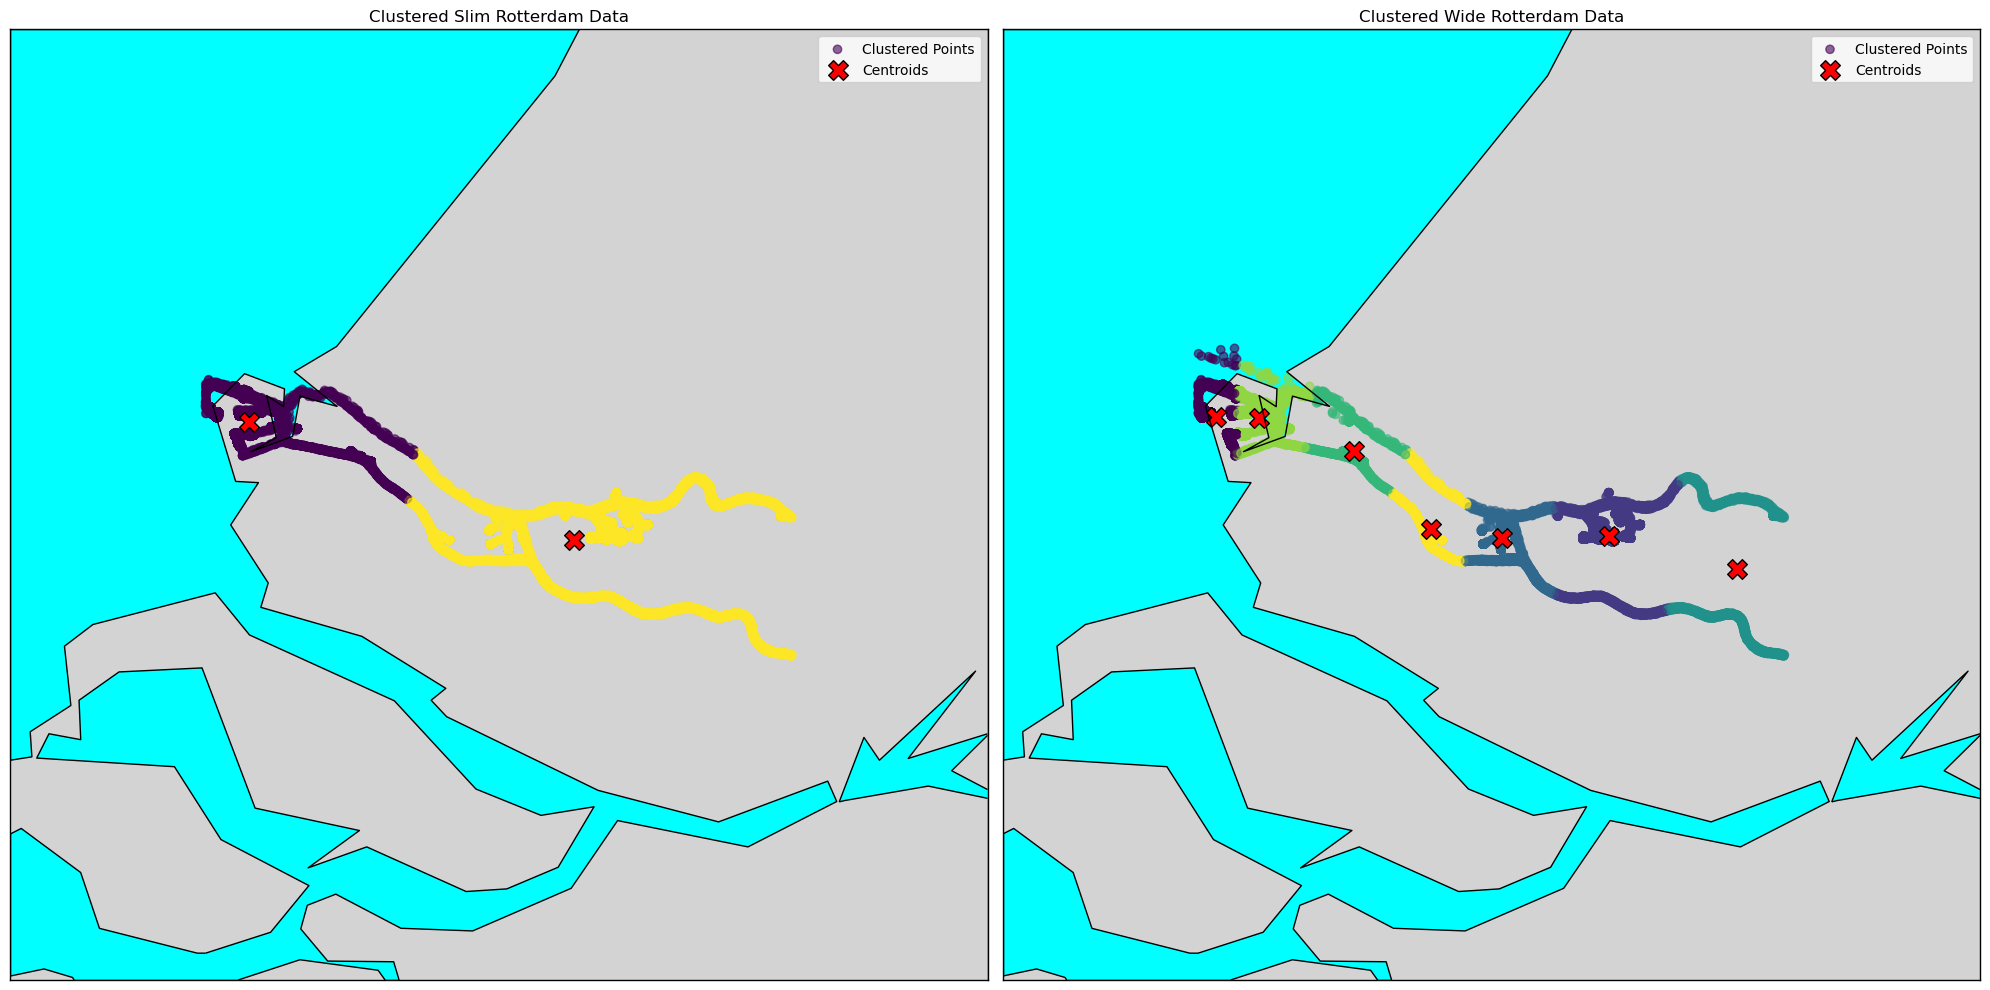

In [16]:
# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 12))

# Plot clustered maps for slim and wide datasets
plot_clustered_map(df_slim_rotterdam, 'Clustered Slim Rotterdam Data', axes[0], clustering_method='kmeans', n_clusters=2)
plot_clustered_map(df_wide_rotterdam, 'Clustered Wide Rotterdam Data', axes[1], clustering_method='kmeans', n_clusters=7)

plt.tight_layout()
plt.show()

Elbow Method and Silhouette Score for Slim Rotterdam Data


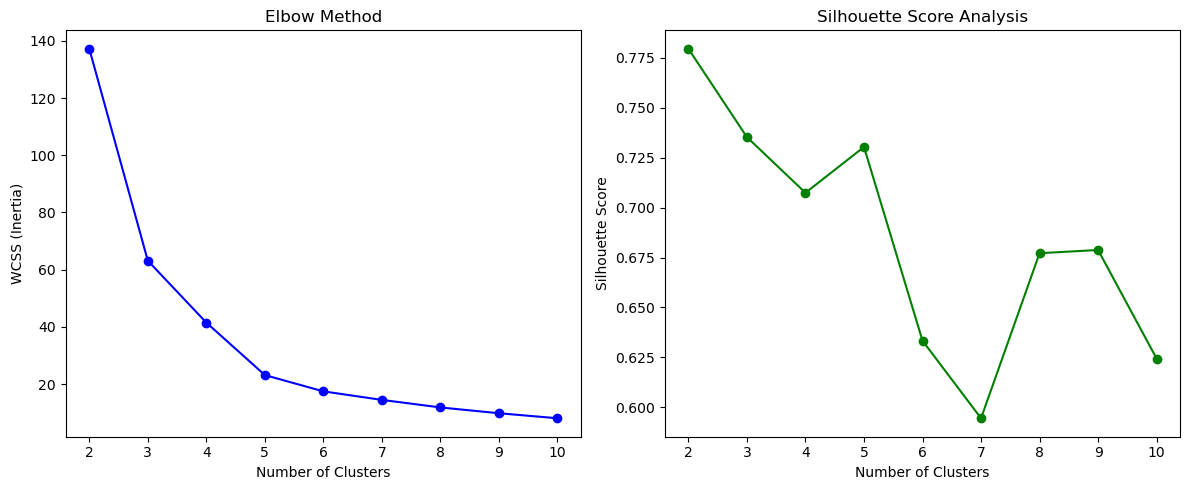

Elbow Method and Silhouette Score for Wide Rotterdam Data


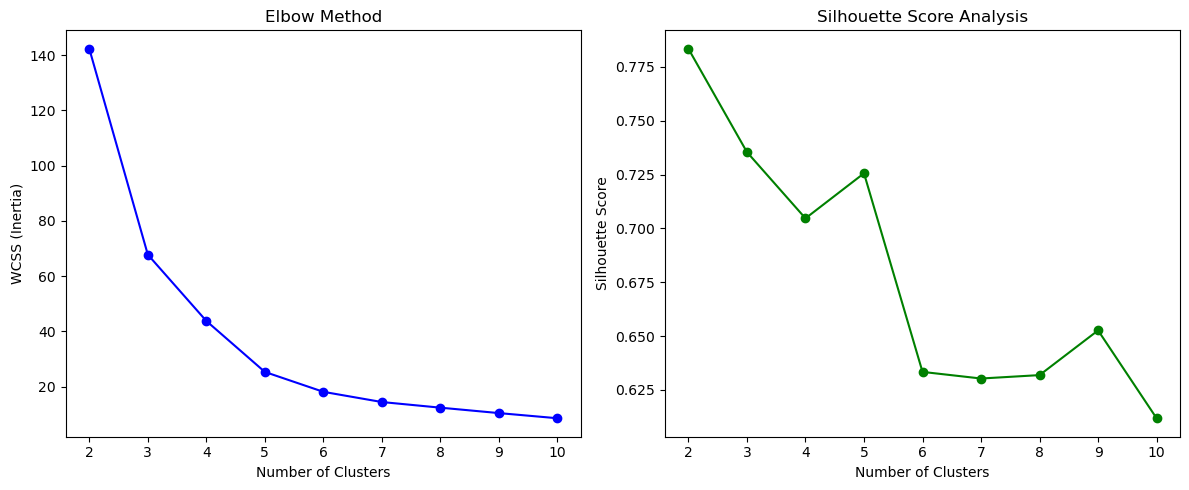

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

def elbow_method_and_silhouette(df, max_clusters=10):
    coords = df[['navigation.location.long', 'navigation.location.lat']].values
    
    wcss = []  # Stores Within-Cluster Sum of Squares
    silhouette_scores = []  # Stores silhouette scores
    
    cluster_range = range(2, max_clusters + 1)
    
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(coords)
        
        wcss.append(kmeans.inertia_)  # Inertia is the WCSS
        silhouette_scores.append(silhouette_score(coords, labels))
    
    # Plot Elbow Method
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(cluster_range, wcss, marker='o', linestyle='-', color='b')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS (Inertia)')
    plt.title('Elbow Method')
    
    # Plot Silhouette Scores
    plt.subplot(1, 2, 2)
    plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-', color='g')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score Analysis')
    
    plt.tight_layout()
    plt.show()

# Apply for df_slim_rotterdam
print("Elbow Method and Silhouette Score for Slim Rotterdam Data")
elbow_method_and_silhouette(df_slim_rotterdam)

# Apply for df_wide_rotterdam
print("Elbow Method and Silhouette Score for Wide Rotterdam Data")
elbow_method_and_silhouette(df_wide_rotterdam)

In [18]:
def compute_silhouette_scores(df, max_clusters=10):
    coords = df[['navigation.location.long', 'navigation.location.lat']].values
    
    results = []  # List to store results
    
    for k in range(2, max_clusters + 1):  # Start from 2 clusters
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(coords)
        
        silhouette_avg = silhouette_score(coords, labels)
        results.append({'Number of Clusters': k, 'Silhouette Score': silhouette_avg})
    
    return pd.DataFrame(results)

# Compute silhouette scores for both datasets
silhouette_slim = compute_silhouette_scores(df_slim_rotterdam)
silhouette_wide = compute_silhouette_scores(df_wide_rotterdam)

# Display results
print("Silhouette Scores for Slim Rotterdam Data:")
print(silhouette_slim)

print("\nSilhouette Scores for Wide Rotterdam Data:")
print(silhouette_wide)

Silhouette Scores for Slim Rotterdam Data:
   Number of Clusters  Silhouette Score
0                   2          0.779581
1                   3          0.735306
2                   4          0.707425
3                   5          0.730397
4                   6          0.633295
5                   7          0.594462
6                   8          0.677163
7                   9          0.678765
8                  10          0.624386

Silhouette Scores for Wide Rotterdam Data:
   Number of Clusters  Silhouette Score
0                   2          0.783375
1                   3          0.735418
2                   4          0.704659
3                   5          0.725580
4                   6          0.633371
5                   7          0.630301
6                   8          0.631883
7                   9          0.652637
8                  10          0.611854


Elbow Method and Silhouette Score for Slim Rotterdam Data


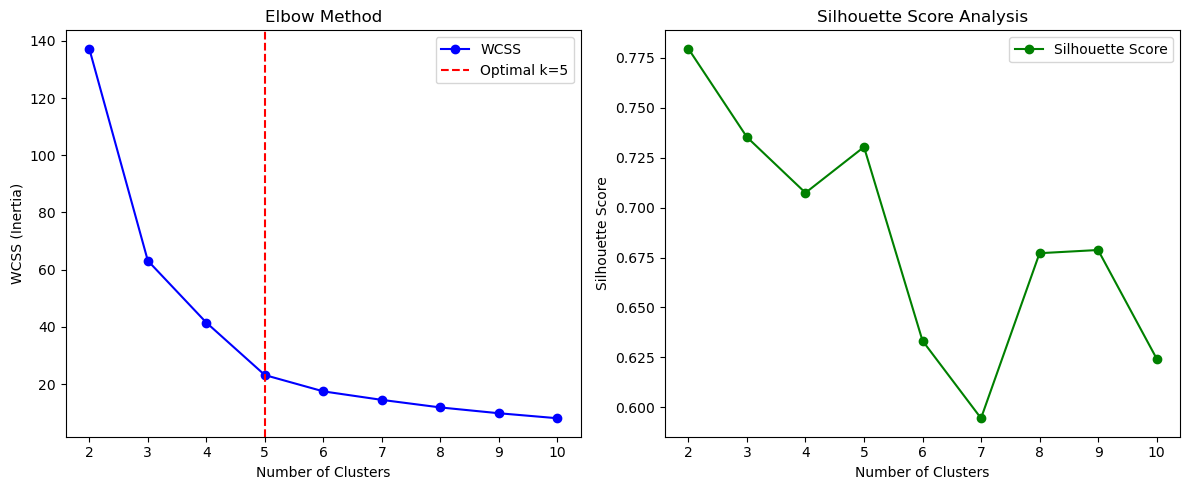

Optimal number of clusters (Elbow Method): 5
Elbow Method and Silhouette Score for Wide Rotterdam Data


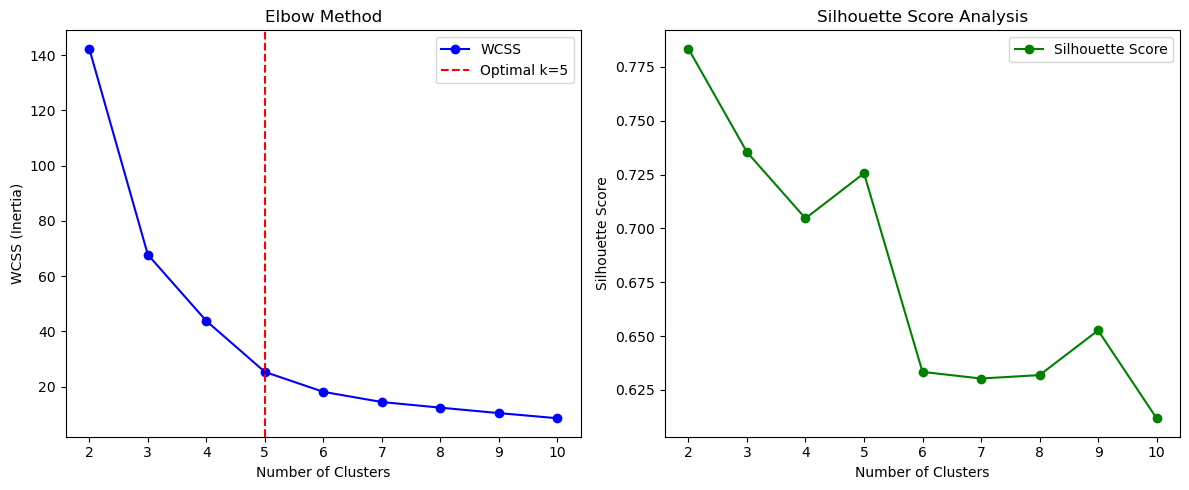

Optimal number of clusters (Elbow Method): 5


In [19]:
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

def elbow_method_and_silhouette(df, max_clusters=10):
    coords = df[['navigation.location.long', 'navigation.location.lat']].values
    
    wcss = []  # Stores Within-Cluster Sum of Squares
    silhouette_scores = []  # Stores silhouette scores
    
    cluster_range = range(2, max_clusters + 1)
    
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(coords)
        
        wcss.append(kmeans.inertia_)  # Inertia is the WCSS
        silhouette_scores.append(silhouette_score(coords, labels))
    
    # Find the optimal number of clusters using KneeLocator
    kl = KneeLocator(cluster_range, wcss, curve="convex", direction="decreasing")
    optimal_k = kl.elbow
    
    # Plot Elbow Method
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(cluster_range, wcss, marker='o', linestyle='-', color='b', label="WCSS")
    if optimal_k:
        plt.axvline(optimal_k, color='r', linestyle='--', label=f'Optimal k={optimal_k}')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS (Inertia)')
    plt.title('Elbow Method')
    plt.legend()
    
    # Plot Silhouette Scores
    plt.subplot(1, 2, 2)
    plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-', color='g', label="Silhouette Score")
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score Analysis')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Optimal number of clusters (Elbow Method): {optimal_k}")
    return optimal_k

# Apply for df_slim_rotterdam
print("Elbow Method and Silhouette Score for Slim Rotterdam Data")
optimal_k_slim = elbow_method_and_silhouette(df_slim_rotterdam)

# Apply for df_wide_rotterdam
print("Elbow Method and Silhouette Score for Wide Rotterdam Data")
optimal_k_wide = elbow_method_and_silhouette(df_wide_rotterdam)